In [1]:
import csv
import os
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import dask.dataframe as dd
import geopandas as gpd
import requests
import pandas as pd
from multiprocessing import Pool

import json
%matplotlib notebook

from shapely.geometry import Point


## First get the census data
We're mostly concerned with populatition, race, and income here. 

In [2]:
census_path='data/ACS/NewYorkCity'
census = gpd.read_file(census_path+'/acs_2015_nyc.shp')
boroughs=['bronx','kings','ny','queens','richmond']
all_df_list=[]
for each in boroughs:
    print(each)
    
    dir_=census_path+'/'+each
    for root,dirs,files in os.walk(dir_):
        df_list = []
        for file in files:
            if file.endswith("with_ann.csv"):
                df_name = file.split('.')[0]
                
                df_name = pd.read_csv(dir_+'/'+file)
                df_name = df_name.iloc[1:]
#                 print(df_name.shape)
                df_list.append(df_name)
        all_ = pd.concat(df_list,axis=1)
        print (all_.shape)
    all_df_list.append(all_)
#     print(all_df_list[0].head(0))
all_boroughs = pd.concat(all_df_list)


bronx
(339, 1469)
kings
(761, 1469)
ny
(288, 1469)
queens
(669, 1469)
richmond
(110, 1469)


## Clean the census data

In [3]:
##white,black,asian,other (non Indian or Hawaian),median income est
all_boroughs_cleaned = all_boroughs[['GEO.id', 'GEO.id2', 'GEO.display-label','HD01_VD01','HD02_VD02','HD01_VD04','HD01_VD06','HD01_VD07','HD01_VD12','HC02_EST_VC02']]

# ## Select the columns that aren't duplicated
all_boroughs_cleaned= all_boroughs_cleaned.ix[:,[0,7,14,21,25,26,28,30,32,34]]
all_boroughs_cleaned=all_boroughs_cleaned.rename(columns={'HD01_VD01':'population','HD02_VD02':'white_alone','HD01_VD04':'black_alone','HD01_VD05':'native_alone','HD01_VD06':'asian_alone','HD01_VD07':'other_race','HD01_VD12':'hispanic','HC02_EST_VC02':'median_income'})
all_boroughs_cleaned.head()

/Users/wenfeixu/anaconda2/envs/geo_wenfei/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """


,GEO.id,GEO.id2,GEO.display-label,population,white_alone,black_alone,asian_alone,other_race,hispanic,median_income
1,1400000US36005000100,36005000100,"Census Tract 1, Bronx County, New York",7703,363,13,0,1855,2307,-
2,1400000US36005000200,36005000200,"Census Tract 2, Bronx County, New York",5403,295,9,0,1496,4095,72034
3,1400000US36005000400,36005000400,"Census Tract 4, Bronx County, New York",5915,405,14,0,1567,3709,74836
4,1400000US36005001600,36005001600,"Census Tract 16, Bronx County, New York",5879,405,0,0,1307,3829,32312
5,1400000US36005001900,36005001900,"Census Tract 19, Bronx County, New York",2591,237,0,0,1024,1436,37936


In [4]:
### Clean census data

## Create a tract GEOID
census['GEOID_tract']=census.apply(lambda x: x['GEOID'][:11],axis=1)

## Spatial join
Merge census shapes to data.

In [5]:
### Join shape with data
census_withdata = census.merge(all_boroughs_cleaned,how='inner',left_on='GEOID_tract',right_on='GEO.id2')

In [6]:
census_withdata.head()

,ACS_HD01_V,AFFGEOID,ALAND,AWATER,BLKGRPCE,COUNTYFP,GEOID,LSAD,NAME,STATEFP,...,GEO.id,GEO.id2,GEO.display-label,population,white_alone,black_alone,asian_alone,other_race,hispanic,median_income
0,1568,1500000US360850156031,332908,0,1,085,360850156031,BG,1,36,...,1400000US36085015603,36085015603,"Census Tract 156.03, Richmond County, New York",4596,391,0,0,37,305,90604
1,1578,1500000US360850156033,393835,0,3,085,360850156033,BG,3,36,...,1400000US36085015603,36085015603,"Census Tract 156.03, Richmond County, New York",4596,391,0,0,37,305,90604
2,1450,1500000US360850156032,320367,0,2,085,360850156032,BG,2,36,...,1400000US36085015603,36085015603,"Census Tract 156.03, Richmond County, New York",4596,391,0,0,37,305,90604
3,720,1500000US360050004001,62874,0,1,005,360050004001,BG,1,36,...,1400000US36005000400,36005000400,"Census Tract 4, Bronx County, New York",5915,405,14,0,1567,3709,74836
4,1435,1500000US360050004002,328785,5538,2,005,360050004002,BG,2,36,...,1400000US36005000400,36005000400,"Census Tract 4, Bronx County, New York",5915,405,14,0,1567,3709,74836


## Then get the 311 noise complaint data
Only want 2016 and newer

In [7]:
def read_csv(filename):
    'converts a filename to a pandas dataframe'
    return pd.read_csv(filename)

def parse_dates(df):
    return pd.to_datetime(df['Created Date'],infer_datetime_format=True)
meta = ('timestamp', pd.Timestamp)


# reader = pd.read_table(LARGE_FILE, chunksize=CHUNKSIZE)
# pool = mp.Pool(4) # use 4 processes

# funclist = []
# for df in reader:
#         # process each data frame
#         f = pool.apply_async(process_frame,[df])
#         funclist.append(f)

# result = 0
# for f in funclist:
#         result += f.get(timeout=10) # timeout in 10 seconds

# Import 311 data
- Generate new features
- Subset only the columns we care about

In [8]:
threeoneone = pd.read_csv('data/311_Service_DOT_since2016.csv')


/Users/wenfeixu/anaconda2/envs/geo_wenfei/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (8,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
threeoneone.columns

Index(['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Agency Name',
       'Complaint Type', 'Descriptor', 'Location Type', 'Incident Zip',
       'Incident Address', 'Street Name', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 1', 'Intersection Street 2', 'Address Type',
       'City', 'Landmark', 'Facility Type', 'Status', 'Due Date',
       'Resolution Description', 'Resolution Action Updated Date',
       'Community Board', 'Borough', 'X Coordinate (State Plane)',
       'Y Coordinate (State Plane)', 'Park Facility Name', 'Park Borough',
       'School Name', 'School Number', 'School Region', 'School Code',
       'School Phone Number', 'School Address', 'School City', 'School State',
       'School Zip', 'School Not Found', 'School or Citywide Complaint',
       'Vehicle Type', 'Taxi Company Borough', 'Taxi Pick Up Location',
       'Bridge Highway Name', 'Bridge Highway Direction', 'Road Ramp',
       'Bridge Highway Segment', 'Garage Lot Name', 'Ferry 

In [10]:
threeoneone=threeoneone[threeoneone['Complaint Type'].str.contains("Street Sign - Missing")]
# threeoneone = threeoneonebthreeoneone['Agency']=='NYPD']

threeoneone['created_date'] = pd.to_datetime(threeoneone['Created Date'],infer_datetime_format=True)
threeoneone['created_year'] = threeoneone['created_date'].apply(lambda x: x.year)


threeoneone['closed_date'] = pd.to_datetime(threeoneone['Closed Date'],infer_datetime_format=True)
threeoneone['due_date'] = pd.to_datetime(threeoneone['Due Date'],infer_datetime_format=True)



new=threeoneone[['Unique Key', 'Created Date', 'Closed Date',
       'Complaint Type', 'Descriptor', 'Location Type', 'Incident Zip',
       'Incident Address', 'Street Name', 'Address Type',
       'City', 'Landmark', 'Facility Type', 'Status', 'Due Date',
       'Resolution Action Updated Date', 'Community Board', 'Borough', 'Latitude',
       'Longitude', 'Location', 'closed_date', 'created_date', 'created_year']]



# Keep only the data from 2016 and beyond

In [11]:
new=new[new['created_year']>=2016]

In [12]:
new.shape

(5534, 24)

In [13]:
new.head()

,Unique Key,Created Date,Closed Date,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Address Type,...,Due Date,Resolution Action Updated Date,Community Board,Borough,Latitude,Longitude,Location,closed_date,created_date,created_year
0,34945045,12/06/2016 12:00:07 PM,07/07/2017 10:50:35 AM,Street Sign - Missing,"No Parking, Standing, Stopping",Street,11101,36-01 48 AVENUE,48 AVENUE,ADDRESS,...,06/06/2017 10:14:44 AM,07/07/2017 10:50:35 AM,02 QUEENS,QUEENS,40.740485,-73.929527,"(40.74048470018655, -73.92952679533303)",2017-07-07 10:50:35,2016-12-06 12:00:07,2016
1,36123304,05/06/2017 02:23:44 PM,08/29/2017 09:54:23 AM,Street Sign - Missing,"No Parking, Standing, Stopping",Street,11377,50-23 70 STREET,70 STREET,ADDRESS,...,11/07/2017 11:18:38 AM,08/29/2017 09:54:23 AM,02 QUEENS,QUEENS,40.736544,-73.894172,"(40.73654361978754, -73.89417194034857)",2017-08-29 09:54:23,2017-05-06 14:23:44,2017
4,36298767,05/28/2017 07:25:19 PM,08/29/2017 09:49:13 AM,Street Sign - Missing,"No Parking, Standing, Stopping",Street,11693,8400 SHORE FRONT PARKWAY,SHORE FRONT PARKWAY,ADDRESS,...,11/27/2017 11:34:32 AM,08/29/2017 09:49:13 AM,14 QUEENS,QUEENS,40.585343,-73.809740,"(40.585342891917264, -73.80974049886493)",2017-08-29 09:49:13,2017-05-28 19:25:19,2017
9,36822417,07/29/2017 10:52:15 AM,08/29/2017 06:32:42 AM,Street Sign - Missing,Bus Stop,Street,10465,510 THROGS NECK EXPRESSWAY,THROGS NECK EXPRESSWAY,ADDRESS,...,01/28/2018 11:29:18 AM,08/29/2017 06:32:42 AM,10 BRONX,BRONX,40.824559,-73.815325,"(40.82455859523637, -73.81532545508581)",2017-08-29 06:32:42,2017-07-29 10:52:15,2017
25,34968780,12/10/2016 01:40:21 AM,06/12/2017 04:02:18 PM,Street Sign - Missing,Street Cleaning - ASP,Street,11372,88-01 ROOSEVELT AVENUE,ROOSEVELT AVENUE,ADDRESS,...,06/11/2017 02:39:56 PM,06/12/2017 04:02:18 PM,03 QUEENS,QUEENS,40.748245,-73.878205,"(40.74824519166426, -73.87820488543346)",2017-06-12 16:02:18,2016-12-10 01:40:21,2016


In [14]:
# new=new[['Unique Key', 'Complaint Type',
#        'Descriptor', 'Location Type', 'Incident Zip', 'Incident Address',
#        'Street Name', 'Address Type', 'City', 'Landmark', 'Facility Type',
#        'Status', 'Due Date', 'Resolution Action Updated Date',
#        'Community Board', 'Borough', 'Latitude', 'Longitude', 'Location',
#        'created_date', 'created_year', 'due_date', 'closed_date']]

# ### Let just use residential complaints
# # new = new[new['Complaint Type']=='Noise - Residential']


# For now, let's just use 20k of points

In [15]:
##  For the sake of this exercise, let's just get a subsample so spatial joins are faster
new_sample = new.copy()

## Create dummy variables for the months

In [16]:
new_sample = pd.concat([new_sample,pd.get_dummies(new_sample['created_date'].apply(lambda x: x.month))],axis=1)

## Turn the 311 data into geopandas dataframe

In [17]:
geom = [Point(xy) for xy in zip(new_sample['Longitude'],new_sample['Latitude'])]
crs = {'init':'epsg:4326'}
threeoneone_geo = gpd.GeoDataFrame(new_sample,crs = crs,geometry=geom)

## Create fix features

In [18]:
threeoneone_geo['fix_time']=threeoneone_geo['closed_date']-threeoneone_geo['created_date']
threeoneone_geo['fix_time_sec']= [x / np.timedelta64(1, 's') for x in threeoneone_geo['fix_time']]

## Filter 311 data
- 311 is not null geometry
- Time to fix is not more than instantaneous

In [19]:
threeoneone_geo = threeoneone_geo[threeoneone_geo['Latitude'].notnull()]
threeoneone_geo = threeoneone_geo[threeoneone_geo['fix_time_sec'].notnull()]
threeoneone_geo = threeoneone_geo[threeoneone_geo['fix_time_sec']>0]

## Change CRS of both 311 and Census to 4326


In [20]:
threeoneone_geo = threeoneone_geo.to_crs({'init': 'epsg:4326'})
census_withdata = census_withdata.to_crs({'init': 'epsg:4326'})

## Then join 311 to census tracts
Get counts. 

In [21]:
# threeoneone_geo_sample = threeoneone_geo.sample(5000)
threeoneone_census = gpd.sjoin(threeoneone_geo,census_withdata, how="inner", op='within')

In [22]:
### Add the complaint count back in
complaint_count=threeoneone_census[['GEOID_tract','Complaint Type']].groupby('GEOID_tract').count().reset_index()
complaint_count=complaint_count.rename(columns={'Complaint Type':"complaint_count"})

avg_fix_time = threeoneone_census[['GEOID_tract','fix_time_sec']].groupby('GEOID_tract').mean().reset_index()
avg_fix_time=avg_fix_time.rename(columns={'fix_time_sec':"avg_fix_time_sec"})


threeoneone_census_complaints = threeoneone_census.merge(complaint_count,how='inner',left_on='GEOID_tract',right_on='GEOID_tract')
threeoneone_census_complaints = threeoneone_census_complaints.merge(avg_fix_time,how='inner',left_on='GEOID_tract',right_on='GEOID_tract')


# print(threeoneone_census_complaints.shape)

## Remove the zero poplation tracts
threeoneone_census_complaints=threeoneone_census_complaints[threeoneone_census_complaints['population']!=0]
print(threeoneone_census_complaints.shape)

## Remove infinites
threeoneone_census_complaints= threeoneone_census_complaints.replace([np.inf, -np.inf], np.nan)

# # threeoneone_census_complaints.columns

(4696, 64)


## Normalize the data a bit


In [23]:
threeoneone_census_complaints['complaint_density']=threeoneone_census_complaints['complaint_count'].astype('float')/threeoneone_census_complaints['population'].astype('float')

# ## Calc race proportions
threeoneone_census_complaints['perc_white']=threeoneone_census_complaints['white_alone'].astype('float')/threeoneone_census_complaints['population'].astype('float')
threeoneone_census_complaints['perc_black']=threeoneone_census_complaints['black_alone'].astype('float')/threeoneone_census_complaints['population'].astype('float')
threeoneone_census_complaints['perc_asian']=threeoneone_census_complaints['asian_alone'].astype('float')/threeoneone_census_complaints['population'].astype('float')
threeoneone_census_complaints['perc_other']=threeoneone_census_complaints['other_race'].astype('float')/threeoneone_census_complaints['population'].astype('float')
threeoneone_census_complaints['perc_hispanic']=threeoneone_census_complaints['hispanic'].astype('float')/threeoneone_census_complaints['population'].astype('float')



# threeoneone_census_complaints['perc_white']=threeoneone_census_complaints['white_alone'].astype('float')/threeoneone_census_complaints['population'].astype('float')
# threeoneone_census_complaints['perc_black']=threeoneone_census_complaints['black_alone'].astype('float')/threeoneone_census_complaints['population'].astype('float')
# threeoneone_census_complaints['perc_asian']=threeoneone_census_complaints['asian_alone'].astype('float')/threeoneone_census_complaints['population'].astype('float')
# threeoneone_census_complaints['perc_other']=threeoneone_census_complaints['other_race'].astype('float')/threeoneone_census_complaints['population'].astype('float')


In [24]:
# threeoneone_census_complaints[['perc_asian','GEOID_tract']].groupby('GEOID_tract').count().reset_index()

## Last bit of data cleaning

In [25]:
threeoneone_census_complaints['median_income'].unique()

array(['55756', '65625', '44689', ..., '45642', '31842', '27222'], dtype=object)

In [26]:

threeoneone_census_complaints['median_income'] =threeoneone_census_complaints['median_income'].str.replace('[^\w\s]','0')
inc_list = []
for each in threeoneone_census_complaints['median_income']:
    try: 
        inc_list.append(float(each))
    except ValueError: 
        inc_list.append(0)
threeoneone_census_complaints['median_income_new'] = inc_list            
    

# ## Still have some weird inf problems
# threeoneone_census_complaints= threeoneone_census_complaints.replace([np.inf, -np.inf], np.nan)

# ## Removing all the null values
threeoneone_census_complaints=threeoneone_census_complaints[~threeoneone_census_complaints['complaint_density'].isin([np.inf])]

# ## let's just clean the data a little further
# threeoneone_census_complaints =threeoneone_census_complaints[threeoneone_census_complaints['median_income_new']!=0]

## Aggregate to the census tract level

In [27]:
# def agg_311(df,count_col,*args):
# #     df = pd.DataFrame(df)
#     df_count = df.groupby(['GEOID_tract']).count()[count_col] ## Pick an arbitrary column to get the aggregated counts
#     df_mean = df.groupby(['GEOID_tract']).mean()[list(args)]
# #     print(df_mean.head())
#     return pd.concat([df_count,df_mean],axis=1)

# agg_311(threeoneone_census_complaints,'Borough','perc_white','perc_black','perc_asian','perc_other','ln_median_income_new','avg_fix_time_sec')
    
    

## Do some exploratory data analysis

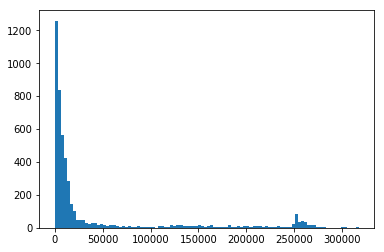

In [28]:
### Plot distribution of fix times
%matplotlib inline
# plt.hist(np.log(threeoneone_geo['fix_time_sec']+1),bins=100)
plt.hist(threeoneone_geo['fix_time_sec']/60,bins=100)
plt.show()

### Is this Poisson distributed?

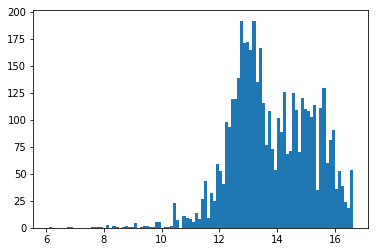

In [29]:
##### Fix time density also log-normal-ish
plt.hist(np.log(threeoneone_census_complaints[threeoneone_census_complaints['avg_fix_time_sec']>0]['avg_fix_time_sec']),bins=100)
plt.show()

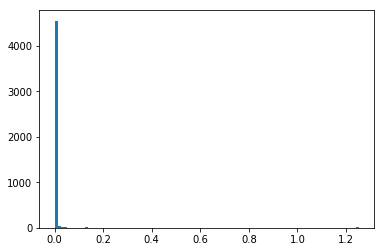

In [30]:
### Complaint density also log-normal
plt.hist(np.log(threeoneone_census_complaints[threeoneone_census_complaints['complaint_density']>0]['complaint_density']+1),bins=100)
plt.show()

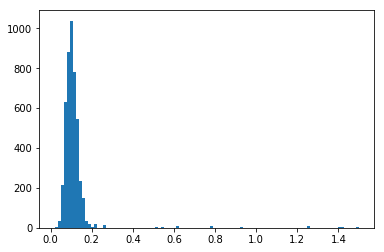

In [31]:
### Race density bimodal?
plt.hist(threeoneone_census_complaints[threeoneone_census_complaints['perc_white']>0]['perc_white'],bins=100)
plt.show()

In [32]:
census_finaldata = census[['GEOID_tract','geometry']].merge(threeoneone_census_complaints.drop('geometry',1),how='outer',left_on='GEOID_tract',right_on = 'GEOID_tract')
census_finaldata = gpd.GeoDataFrame(census_finaldata.drop('geometry',1),geometry=census_finaldata['geometry'],crs=census.crs)

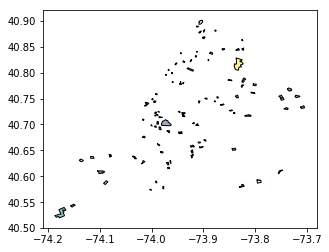

In [33]:
census_finaldata.sample(100).plot()

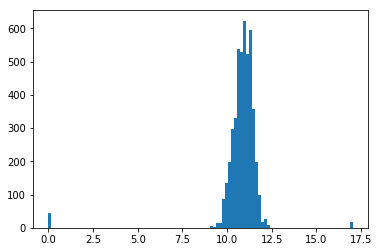

In [34]:
### Income is log-normal
plt.hist(np.log(threeoneone_census_complaints['median_income_new']+1),bins=100)
plt.show()

# Set up Bayesian model

We have a model where $$ y = X\beta+\epsilon$$ and $y$ = the time it takes to fix the complaint, $\beta_0$ = "baseline amount of time it should take", $\beta_1$ = proportion of white, $\beta_2$ = proportion of black,  $\beta_3$ = proportion of asian,  $\beta_4$ = proportion of 'other', $\beta_5$ = median income, $\beta_6$ = count of total number of calls.


In [35]:
threeoneone_census_complaints['ln_median_income_new']= np.log(threeoneone_census_complaints['median_income_new']+1)
threeoneone_census_complaints['ln_complaint_density']= np.log(threeoneone_census_complaints['complaint_density']+1)
threeoneone_census_complaints['population']=threeoneone_census_complaints['population'].astype(float)

In [36]:
threeoneone_census_complaints.columns

Index([                    'Unique Key',                   'Created Date',
                          'Closed Date',                 'Complaint Type',
                           'Descriptor',                  'Location Type',
                         'Incident Zip',               'Incident Address',
                          'Street Name',                   'Address Type',
                                 'City',                       'Landmark',
                        'Facility Type',                         'Status',
                             'Due Date', 'Resolution Action Updated Date',
                      'Community Board',                        'Borough',
                             'Latitude',                      'Longitude',
                             'Location',                    'closed_date',
                         'created_date',                   'created_year',
                                      1,                                2,
                         

In [48]:
y = np.log(threeoneone_census_complaints['avg_fix_time_sec']+1).values

X = threeoneone_census_complaints[['perc_white',\
                                   'perc_black', \
                                   'perc_asian',\
                                   'perc_hispanic',\
                                   'perc_other', \
                                   'ln_median_income_new', \
                                   'ln_complaint_density',\
                                   'population',\
                                   1,2,3,4,5,6,7,8,9,10,11,12]].values

## Optional intercept
ones_ = np.ones(threeoneone_census_complaints.shape[0]).reshape((-1,1))
X = np.hstack((ones_,X))

In [93]:
alpha+ beta_race.tag.test_value.reshape((-1,1)).T.dot(X[:,1:6].T)+ beta_income.tag.test_value.reshape((-1,1)).T.dot(X[:,6:7].T) +beta_complaint.tag.test_value.reshape((-1,1)).T.dot(X[:,7:8].T) +beta_pop.tag.test_value.reshape((-1,1)).T.dot(X[:,8:9].T)

# beta_pop.tag.test_value.reshape((-1,1)).T.dot(X[:,8:9].T)

Elemwise{add,no_inplace}.0

In [ ]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    
    # Priors for unknown model parameters
    sigma = pm.HalfNormal('sigma', sd=0.1)
    alpha = pm.Uniform("alpha", -10, 10)
    beta_race = pm.Uniform("betas_race", -50, 50, shape=5)
    beta_income = pm.Uniform('beta_income', -50, 50)
    beta_complaint = pm.Uniform('beta_complaint',-50, 50)
    beta_pop = pm.Uniform('beta_pop',-50, 50)
#     dummy_month = pm.Uniform('dummy_month',1,12,shape=12)
    mu = alpha+ beta_race.reshape((-1,1)).T.dot(X[:,1:6].T)+ beta_income.reshape((-1,1)).T.dot(X[:,6:7].T) +beta_complaint.reshape((-1,1)).T.dot(X[:,7:8].T)+beta_pop.reshape((-1,1)).T.dot(X[:,8:9].T)

    #     mu = alpha+ X[:,1:6].dot(beta_race)+ X[:,6:7].dot(beta_income) +X[:,7:8].dot(beta_complaint)+X[:,8:9].dot(beta_pop)
#     +X[:,9:21].doc(dummy_month)
    Y_obs = pm.Normal('Y_obs', mu=mu.T, sd=sigma, observed=y)
#     Y_obs = pm.Poisson('Y_obs', mu=mu, observed=y)
        
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

INFO (theano.gof.compilelock): Refreshing lock /Users/wenfeixu/.theano/compiledir_Darwin-15.6.0-x86_64-i386-64bit-i386-3.6.1-64/lock_dir/lock
  2%|▏         | 258/15000 [07:31<7:25:39,  1.81s/it]

In [ ]:
plt.figure(figsize=(7, 7))
pm.traceplot(trace)
plt.tight_layout();

In [ ]:
# from scipy import optimize
# map_estimate = pm.find_MAP(model=model)
# map_estimate

In [ ]:
betas_race_samples.mean(axis=0)

In [ ]:
betas_race_samples = trace['betas_race']
alpha_samples = trace['alpha']
beta_income_samples = trace['beta_income']
beta_complaint_samples = trace['beta_complaint']

In [ ]:
map_estimate['betas_race_interval__'].reshape((-1,1)).T.dot(X[:,1:5].T).shape

In [ ]:
y_hat = map_estimate['alpha_interval__'] + map_estimate['betas_race_interval__'].reshape((-1,1)).T.dot(X[:,1:5].T) +\
map_estimate['beta_income_interval__'].reshape((-1,1)).T.dot(X[:,5:6].T)+ \
map_estimate['beta_complaint_interval__'].reshape((-1,1)).T.dot(X[:,6:7].T)
plt.scatter(y_hat.T,y)
plt.show()

In [ ]:
pm.forestplot(trace)